# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

207Notes:
 -  reproduce figure 6 (rows are random restarts, see main paper) with NLM 2 hidden layers 50-50
 -  new code: plot the priors
 -  verify in paper, how many iterations were done for this figure, verify data generating process
 - 
 -  

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

### Generate Data

In [2]:
number_of_points = 50
x_train, y_train, x_test = utils.generate_data(number_of_points)




#### Define NN Hyperparameters

In [3]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 50
hidden_layers = 2
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':100, 
          'random_restarts':1,
          'optimizer':'adam'}


### Run Vanilla Nueral Network

 Iteration 0 lower bound 228982.95863738237; gradient mag: 662431.49927202180.413 Seconds


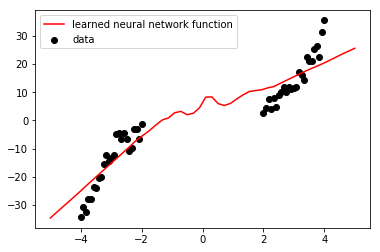

In [4]:
nn = Feedforward(architecture, random=random)

t0 = time.time()
#fit my neural network to minimize MSE on the given data
nn.fit(x_train, y_train, params)
nn_time = np.round(time.time() - t0, 3)

print(f"{nn_time} Seconds")

#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)

#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()


### NLM Demo

In [ ]:
# test
prior_var = .1
y_var = 1.0
regularization_param_nlm = 5
test_nlm = NLM(prior_var,y_var, regularization_param_nlm,architecture, random_state = np.random.RandomState(0))

In [ ]:
params = {'step_size':1e-3, 
          'max_iteration':500, 
          'random_restarts':1,
          'optimizer':'adam'}

t0 = time.time()
test_nlm.train(x_train,y_train, params)
nlm_time = np.round(time.time() - t0, 3)
print(f"{nlm_time} Seconds")

In [ ]:
for predictive_name, boolean in {"prior NLM":True, "posterior NLM":False}.items():
    predictives, predictive_samples = test_nlm.predict(x_test,prior = boolean)
    bh.viz_pp_samples(x_train, y_train,x_test.flatten(),predictive_samples,predictive_name)